Dataset: Market price of natural gas at the end of each month starting 31 October 2020 to 30 September 2024.
    
Task: Analyze the data to estimate the purchase price of gas at any given date and extrapolate it for one year into the future.

In [1]:
##basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Nat_Gas.csv')
data.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [3]:
##check for null values
data.isnull().sum()

Dates     0
Prices    0
dtype: int64

In [4]:
##check 'Dates' datatype
type(data['Dates'][0])

str

In [5]:
##check 'Prices' datatype
type(data["Prices"][0])

numpy.float64

In [6]:
##check distibution for 'Prices'
data['Prices'].describe()

count    48.000000
mean     11.207083
std       0.757897
min       9.840000
25%      10.650000
50%      11.300000
75%      11.625000
max      12.800000
Name: Prices, dtype: float64

In [7]:
data['Dates'] = pd.to_datetime(data['Dates'])

data.set_index('Dates', inplace=True)

data.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


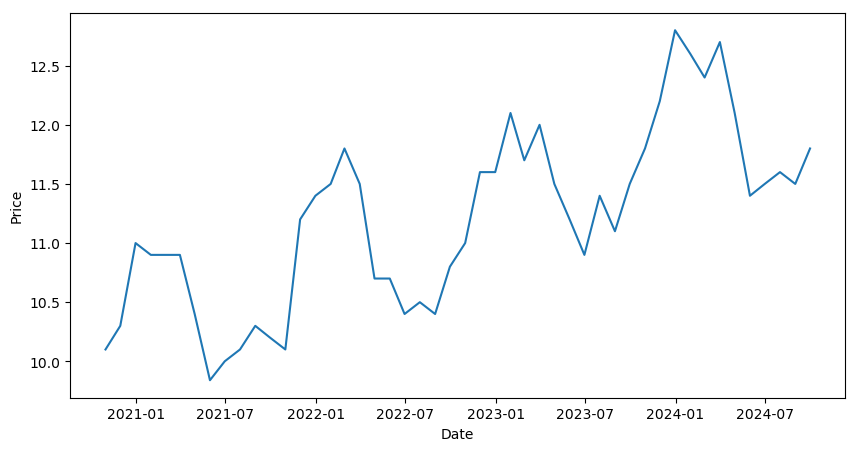

In [8]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(data['Prices'])
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.show()

In [9]:
## time series appears to have inconsistent mean over time and displays visual seasonality
## appears to be a unit-root case
## confirm with ADF test

In [10]:
from statsmodels.tsa.stattools import adfuller

## H0: time series is not stationary --> NULL HYPOTHESIS
## H1: time series is stationary --> ALTERNATE HYPOTHESIS

##test function
def adf_test(data):
    
    labels = ['adf', 'pvalue', 'usedlags', 'nobs', 'critical_values', 'icbest'] ##labels confirmed from adfuller documentation
    results = adfuller(data)
    
    dct = dict(zip(labels, results)) ## dictionary with labels as keys and results as values
    
    ## print results
    for label, value in dct.items():
        print(f"{label}: {value}")
        
    ## stationarity check
    if dct['pvalue'] <= 0.05:
        print(f"\nNULL HYPOTHESIS REJECTED --> TIME SERIES IS STATIONARY")
    else:
        print(f"\nNULL HYPOTHESIS SUSTAINED --> TIME SERIES IS NOT STATIONARY")

In [11]:
## check
adf_test(data['Prices'])

adf: 0.21807686170000262
pvalue: 0.9732574388448695
usedlags: 10
nobs: 37
critical_values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
icbest: 10.198475035166396

NULL HYPOTHESIS SUSTAINED --> TIME SERIES IS NOT STATIONARY


### Important:

Since the time series is seasonal and non-stationary, the **SARIMAX** model might be a good choice for predictive analysis.

The model requires four hyperparameters as inputs durinf instantiation, them being:
1) P is the order of the model for Auto Regressive parameters
2) D is the order of the model for differences
3) Q is the order of the model for Moving Average parameters
4) s is the order of the model for periodicity or seasonality

In [12]:
## perform seasonal differencing over 12 steps (12 steps account for seasonality of the time series data)

data['Prices_Seasonal_Difference'] = data['Prices'] - data['Prices'].shift(12)
data.head()

,Prices,Prices_Seasonal_Difference
Dates,,
2020-10-31,10.1,NaN
2020-11-30,10.3,NaN
2020-12-31,11.0,NaN
2021-01-31,10.9,NaN
2021-02-28,10.9,NaN


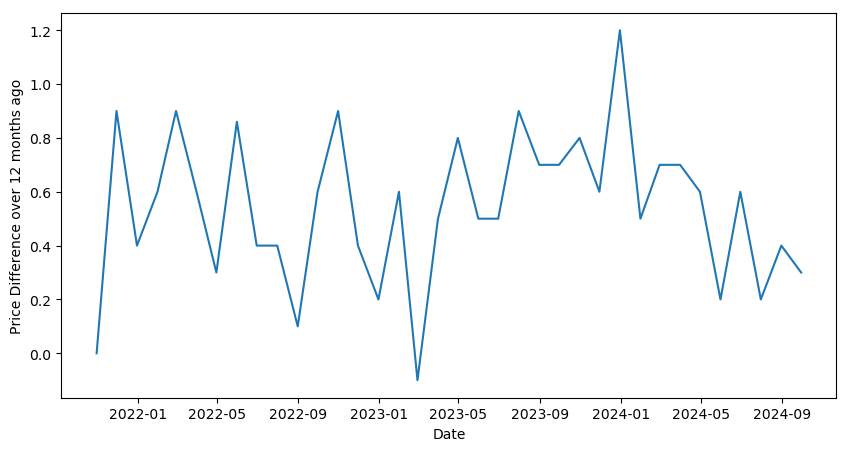

In [13]:
## visualize 'Prices_Seasonal_Differnece'

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(data['Prices_Seasonal_Difference'])
ax.set_xlabel('Date')
ax.set_ylabel('Price Difference over 12 months ago')

plt.show()

In [14]:
## check for stationarity

adf_test(data['Prices_Seasonal_Difference'].dropna())

adf: -6.338337757875165
pvalue: 2.7945314748502356e-08
usedlags: 0
nobs: 35
critical_values: {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}
icbest: 9.063044300216497

NULL HYPOTHESIS REJECTED --> TIME SERIES IS STATIONARY


**Important**: Since the time series demonstrates stationarity after 1 differencing, the value for D is 1.

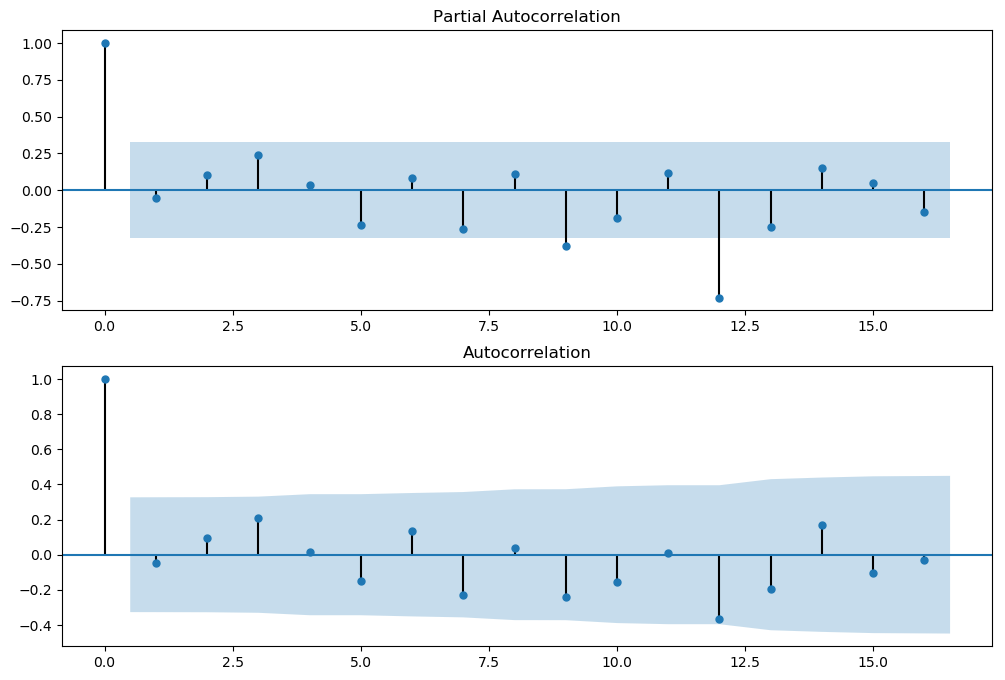

In [15]:
## plot the PACF and the ACF
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(data['Prices_Seasonal_Difference'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_acf(data['Prices_Seasonal_Difference'].dropna(), ax=ax2)

**Important**: Since both the partial autocorrelations and the correlations are within the respective error bands post the respective first values, we can conclude that the appropriate value for both P and Q is 12.

Text(0.5, 1.0, 'Fourth 12 Months')

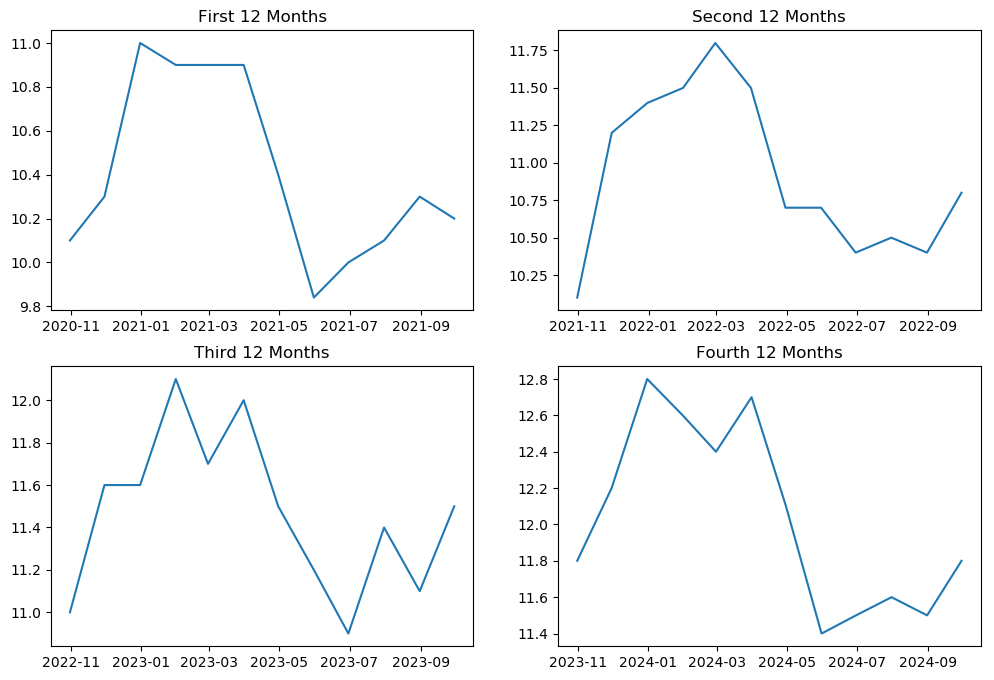

In [16]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(data['Prices'][:12])
plt.title('First 12 Months')

plt.subplot(2,2,2)
plt.plot(data['Prices'][12:24])
plt.title('Second 12 Months')

plt.subplot(2,2,3)
plt.plot(data['Prices'][24:36])
plt.title('Third 12 Months')

plt.subplot(2,2,4)
plt.plot(data['Prices'][36:48])
plt.title('Fourth 12 Months')

**Important**: It is confirmed that the trends are repeated every 12 months. Therefore, the value for s is 12.

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
model = SARIMAX(data['Prices'], order=(1,1,1), seasonal_order=(1,1,1,12)) ##order=(P,D,Q), seasonal_order=(P,D,Q,s)
model_fit = model.fit()

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


In [19]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  -0.641
Date:                            Mon, 31 Jul 2023   AIC                             11.281
Time:                                    04:57:02   BIC                             19.058
Sample:                                10-31-2020   HQIC                            13.966
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2256      0.274     -0.822      0.411      -0.764       0.312
ma.L1         -0.7651      0.206     -3.708      0.000      -1.170      -0.361
ar.S.L12      -0.1637      0.431     -0.379      0.704      -1.009       0.682
ma.S.L12      -0.9791     23.774     -0.041      0.967     -47.575      45.617
sigma2         0.0343      0.805      0.043      0.966      -1.543       1.611
===================================================================================
Ljung-Box (Q):                       50.55   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.03   Prob(JB):                         0.71
Heteroskedasticity (H):               0.82   Skew:                            -0.11
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

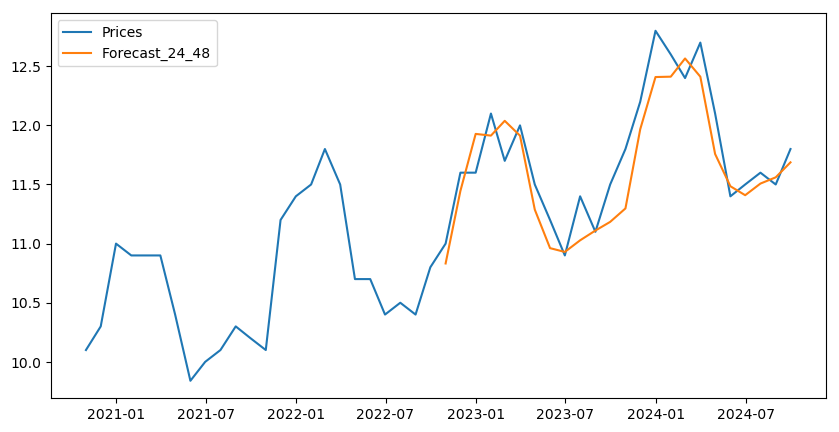

In [20]:
data['Forecast_24_48'] = model_fit.predict(start=24, end=48, dynamic=True)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(data['Prices'])
ax.plot(data['Forecast_24_48'])
ax.legend(['Prices','Forecast_24_48'])

In [21]:
## forecast for next 12 months
model_fit.forecast(steps=12)

2024-10-31    11.987261
2024-11-30    12.610003
2024-12-31    12.925111
2025-01-31    13.064641
2025-02-28    13.012201
2025-03-31    13.043946
2025-04-30    12.439571
2025-05-31    12.121278
2025-06-30    11.987201
2025-07-31    12.211956
2025-08-31    12.131924
2025-09-30    12.378297
Freq: M, dtype: float64

In [22]:
## creating extended dataframe

future_data = pd.DataFrame(model_fit.forecast(steps=12).values, index=model_fit.forecast(steps=12).index, columns=['Forecast_48_60'])

total_data = pd.concat([data, future_data])

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


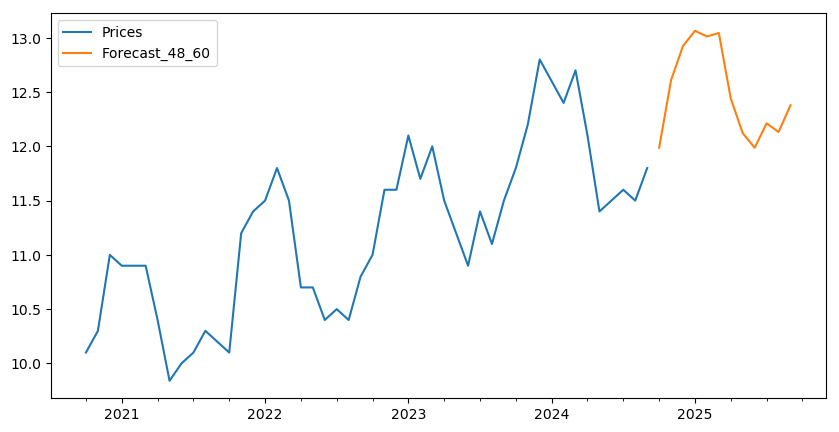

In [23]:
## visualization

total_data[['Prices','Forecast_48_60']].plot(figsize=(10,5))

In [24]:
import calendar

In [25]:
def get_price():
    
    date = input("Enter date (YYYY-MM-DD): ")
    date = pd.to_datetime(date)
    
    year = date.year
    month = date.month
    
    month_len = calendar.monthlen(year, month) ## max days in the month belonging to the date
    
    date = date.replace(day=month_len) ## replace date with last date of that month
    
    start_date = data.index[-1]
    
    steps = len(pd.date_range(start=start_date, end=date, freq='M')) - 1 ## no. of steps to forecast
    
    price = model_fit.forecast(steps=steps)[-1] ## return last value of the forecast
    
    return price

In [26]:
get_price()

Enter date (YYYY-MM-DD): 2025-05-27


12.121277605201533

In [27]:
get_price()

Enter date (YYYY-MM-DD): 2026-12-14


14.033568895301181